In [1]:
import pandas as pd
import numpy as np
import xgboost
import sklearn
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from shap import TreeExplainer, Explanation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

In [2]:
hd_dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",sep=',',header=None)
hd_dataset.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

print (hd_dataset.shape)

(303, 14)


In [3]:
hd_dataset.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  num  
0    3.0  0.0  6.0    0  
1    2.0  3.0  3.0    2  
2    2.0  2.0  7.0    1  
3    3.0  0.0  3.0    0  
4    1.0  0.0  3.0    0

In [4]:
hd_dataset.num.value_counts()

0    164
1     55
2     36
3     35
4     13
Name: num, dtype: int64

##### Data Description: 
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type 
    -- Value 1: typical angina
    -- Value 2: atypical angina
    -- Value 3: non-anginal pain
    -- Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
    -- Value 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    -- Value 1: normal
    -- Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
     -- Value 1: upsloping
     -- Value 2: flat
     -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: Results of the blood flow observed via the radioactive dye.
      3 = normal; 
      6 = fixed defect; (no blood flow in some part of the heart)
      7 = reversable defect (a blood flow is observed but it is not normal)
14. num: diagnosis of heart disease (angiographic disease status)

In [5]:
# outcome: whether get heart disease or not
hd_dataset.loc[hd_dataset.num>0,'num'] = 1
print(hd_dataset.num.value_counts())
hd_dataset = hd_dataset.rename(columns={'num':'HD'})
#hd_dataset.isnull().sum()

0    164
1    139
Name: num, dtype: int64


In [6]:
hd_dataset.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  HD  
0    3.0  0.0  6.0   0  
1    2.0  3.0  3.0   1  
2    2.0  2.0  7.0   1  
3    3.0  0.0  3.0   0  
4    1.0  0.0  3.0   0

In [7]:
hd_dataset = hd_dataset[hd_dataset.ca != '?' ]
hd_dataset = hd_dataset[hd_dataset.thal != '?' ]
hd_dataset = hd_dataset.reset_index(drop=True)
hd_dataset.shape

(297, 14)

In [8]:
# Data processing, 5 categorical variables
#cp - chest_pain_type
hd_dataset.loc[hd_dataset['cp'] == 4, 'cp'] = 'asymptomatic' # reference
#hd_dataset.loc[hd_dataset['cp'] == 1, 'cp'] = 'typical angina'
hd_dataset.loc[hd_dataset['cp'] == 1, 'cp'] = 'angina'
hd_dataset.loc[hd_dataset['cp'] == 2, 'cp'] = 'angina'
#hd_dataset.loc[hd_dataset['cp'] == 2, 'cp'] = 'atypical angina'
hd_dataset.loc[hd_dataset['cp'] == 3, 'cp'] = 'non-anginal pain'

#restecg - rest_ecg_type
hd_dataset.loc[hd_dataset['restecg'] == 1, 'restecg'] = 'normal'
hd_dataset.loc[hd_dataset['restecg'] == 0, 'restecg'] = 'left ventricular hypertrophy'
hd_dataset.loc[hd_dataset['restecg'] == 2, 'restecg'] = 'ST-T wave abnormality'

#slope - st_slope_type
hd_dataset.loc[hd_dataset['slope'] == 2, 'slope'] = 'flat'
hd_dataset.loc[hd_dataset['slope'] == 3, 'slope'] = 'downsloping'
hd_dataset.loc[hd_dataset['slope'] == 1, 'slope'] = 'upsloping'

#thal - thalassemia_type
#hd_dataset.loc[hd_dataset['thal'] == '3', 'thal'] = 8.0
hd_dataset.loc[hd_dataset['thal'] == '3.0', 'thal'] = 'normal'
hd_dataset.loc[hd_dataset['thal'] == '6.0', 'thal'] = 'fixed defect'
hd_dataset.loc[hd_dataset['thal'] == '7.0', 'thal'] = 'reversable defect'

# ca
hd_dataset.loc[hd_dataset['ca'] == '2.0', 'ca'] = '>1'
hd_dataset.loc[hd_dataset['ca'] == '3.0', 'ca'] = '>1'
#hd_dataset.ca = pd.to_numeric(hd_dataset.ca)
hd_dataset = pd.get_dummies(hd_dataset, drop_first=False)
hd_dataset = hd_dataset.drop(['cp_non-anginal pain','restecg_normal','slope_flat','thal_normal','ca_0.0'], axis = 1)
#hd_dataset = hd_dataset.drop(['cp_asymptomatic','restecg_normal','slope_flat','thal_normal'], axis = 1)

In [9]:
# process 5 numeric variables, using min-max normalization
hd_dataset.age=(hd_dataset.age-np.min(hd_dataset.age))/(np.max(hd_dataset.age)-np.min(hd_dataset.age))
hd_dataset.trestbps=(hd_dataset.trestbps-np.min(hd_dataset.trestbps))/(np.max(hd_dataset.trestbps)-np.min(hd_dataset.trestbps))
hd_dataset.chol=(hd_dataset.chol-np.min(hd_dataset.chol))/(np.max(hd_dataset.chol)-np.min(hd_dataset.chol))
hd_dataset.thalach=(hd_dataset.thalach-np.min(hd_dataset.thalach))/(np.max(hd_dataset.thalach)-np.min(hd_dataset.thalach))
hd_dataset.oldpeak=(hd_dataset.oldpeak-np.min(hd_dataset.oldpeak))/(np.max(hd_dataset.oldpeak)-np.min(hd_dataset.oldpeak))
#hd_dataset.ca=(hd_dataset.ca-np.min(hd_dataset.ca))/(np.max(hd_dataset.ca)-np.min(hd_dataset.ca))

In [10]:
hd_dataset.shape

(297, 19)

## 1. Model-Training

In [12]:
x_frame = hd_dataset.drop('HD',axis=1)
y = hd_dataset.HD
X_train,X_test,Y_train,Y_test = train_test_split(x_frame,y, test_size=0.2, random_state=0)

In [13]:
# 1. random forest
rf = RandomForestClassifier(n_estimators = 1000,random_state=0,
                            criterion= 'gini',
                            min_samples_split=5,max_features=3).fit(X_train, Y_train)
y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
print("AUC OF THE MODEL: ", metrics.auc(fpr, tpr))

rf_pred_train = rf.predict_proba(X_train)[:,1]
rf_pred_train = pd.DataFrame(rf_pred_train)
#rf_pred_train.to_csv('ncslc_rf_train_predicted_probs.csv',index=False)

AUC OF THE MODEL:  0.7833333333333333


In [18]:
# 2. xgboost
xgb = xgboost.XGBClassifier(random_state=0,max_depth = 3,
                           eta = 0.5).fit(X_train, Y_train)
y_pred = xgb.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
print("AUC OF THE MODEL: ", metrics.auc(fpr, tpr))

xgb_pred_train = xgb.predict_proba(X_train)[:,1]
xgb_pred_train = pd.DataFrame(xgb_pred_train)
#xgb_pred_train.to_csv('ncslc_xgb_train_predicted_probs.csv',index=False)

AUC OF THE MODEL:  0.7666666666666667


In [19]:
# 3. mlp
mlp = MLPClassifier(random_state=0, max_iter=2000).fit(X_train, Y_train)
y_pred = mlp.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
print("AUC OF THE MODEL: ", metrics.auc(fpr, tpr))

mlp_pred_train = mlp.predict_proba(X_train)[:,1]
mlp_pred_train = pd.DataFrame(mlp_pred_train)
#mlp_pred_train.to_csv('ncslc_mlp_train_predicted_probs.csv',index=False)

AUC OF THE MODEL:  0.8333333333333334


In [20]:
# 4. logistic regression
logit = sklearn.linear_model.LogisticRegression(penalty='l1',random_state=0,max_iter=500,solver='liblinear').fit(X_train, Y_train)
y_pred = logit.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
print("AUC OF THE MODEL: ", metrics.auc(fpr, tpr))
#print('Accuracy Score:  {:3.4%}'.format(accuracy_score(Y_test,y_pred)))

logit_pred_train = logit.predict_proba(X_train)[:,1]
logit_pred_train = pd.DataFrame(logit_pred_train)
#logit_pred_train.to_csv('ncslc_logit_train_predicted_probs.csv',index=False)

AUC OF THE MODEL:  0.85


<AxesSubplot:title={'center':'logistic coefficients'}>

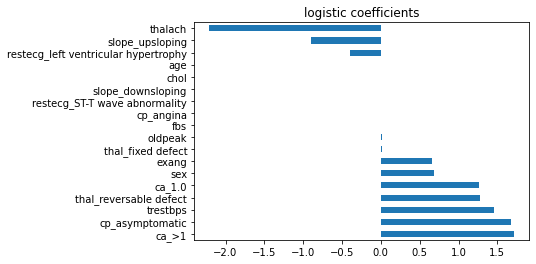

In [23]:
coeffecients = pd.DataFrame(logit.coef_.ravel(),X_train.columns)
coeffecients.columns = ['Coeffecient']
coeffecients.sort_values(by=['Coeffecient'],inplace=True,ascending=False)
coeffecients['Coeffecient'].plot(kind="barh",title='logistic coefficients')


In [27]:
Y_train.iloc[0]

1

## 2. Model-agnostic Method: shapely value

In [24]:
explainer_rf = shap.KernelExplainer(rf.predict_proba, X_train, link="logit")
shap_values_rf = explainer_rf.shap_values(X_train, nsamples=100)

Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/237 [00:00<?, ?it/s]

In [25]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][0,:], X_train.iloc[0,:], link="logit")

In [35]:
explainer_xgb = shap.KernelExplainer(xgb.predict_proba, X_train, link="logit")
shap_values_xgb = explainer_xgb.shap_values(X_train, nsamples=100)

Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/237 [00:00<?, ?it/s]

In [158]:
shap.force_plot(explainer_xgb.expected_value[1], shap_values_xgb[1][0,:], X_train.iloc[0,:], link="logit")

In [27]:
explainer_mlp = shap.KernelExplainer(mlp.predict_proba, X_train, link="logit")
shap_values_mlp = explainer_mlp.shap_values(X_train, nsamples=100)

Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/237 [00:00<?, ?it/s]

In [36]:
shap.initjs()
shap.force_plot(explainer_mlp.expected_value[1], shap_values_mlp[1][0,:], X_train.iloc[0,:], link="logit")

## 3. TreeExplainer for XGboost and RF

(237, 18, 2)


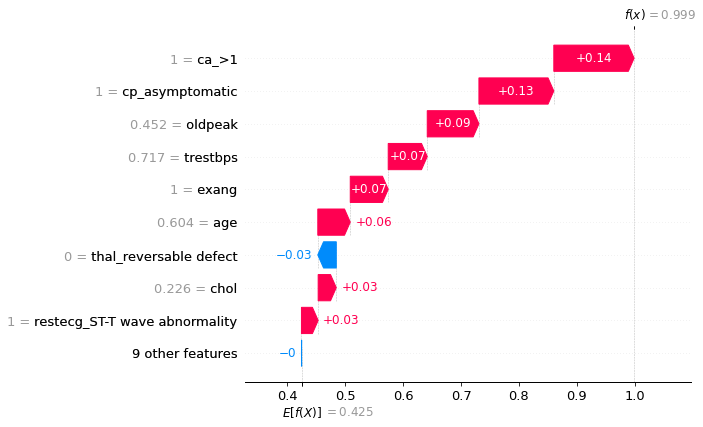

In [34]:
Tree_explainer_xgb = shap.TreeExplainer(xgb,model_output='predict_proba',data=X_train)
Tree_shap_values_xgb = Tree_explainer_xgb(X_train)
print(Tree_shap_values_xgb.shape)
shap.plots.waterfall(Tree_shap_values_xgb[0,:,1] ) 

In [35]:
shap.plots.force(Tree_shap_values_xgb[0,:,1])

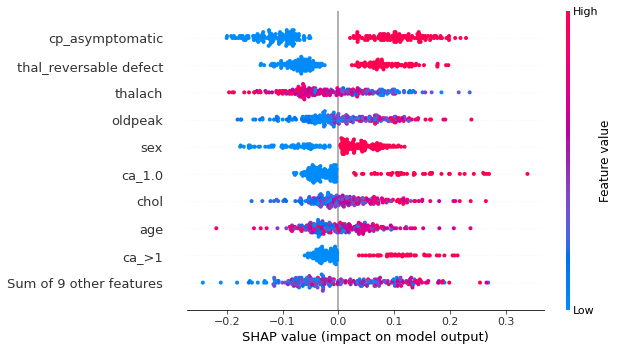

In [36]:
shap.plots.beeswarm(Tree_shap_values_xgb[:,:,1])

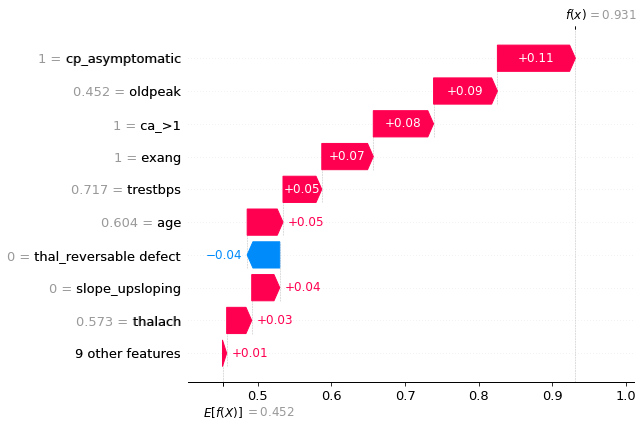

In [24]:
Tree_explainer_rf = TreeExplainer(rf)
Tree_shap_values_rf = Tree_explainer_rf(X_train)

#visualize the first prediction's explanation
shap.plots.waterfall(Tree_shap_values_rf[0,:,1])

In [25]:
shap.initjs()
shap.plots.force(Tree_shap_values_rf[0,:,1])

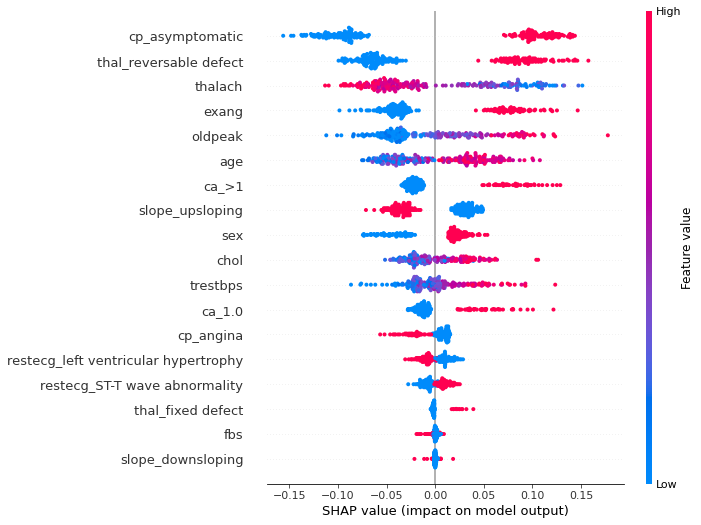

In [26]:
shap.plots.beeswarm(Tree_shap_values_rf[:,:,1],show=False,max_display=20)
plt.savefig('global_shap_hd_rf.png',dpi = 300,bbox_inches='tight')

## 4. LIME

In [31]:
import lime
import lime.lime_tabular
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,  
                                                        mode='classification',
                                                        training_labels=Y_train,
                                                        feature_names=X_train.columns.values.tolist(),
                                                       random_state=0)
exp_rf = lime_explainer.explain_instance(X_train.iloc[0,:],rf.predict_proba, num_features=8)

exp_rf.show_in_notebook(show_table=True)


In [104]:
exp_xgb = lime_explainer.explain_instance(X_train.iloc[0,:],xgb.predict_proba, num_features=8)
exp_xgb.show_in_notebook(show_table=True)

In [32]:
exp_mlp = lime_explainer.explain_instance(X_train.iloc[0,:],mlp.predict_proba, num_features=8)
exp_mlp.show_in_notebook(show_table=True)

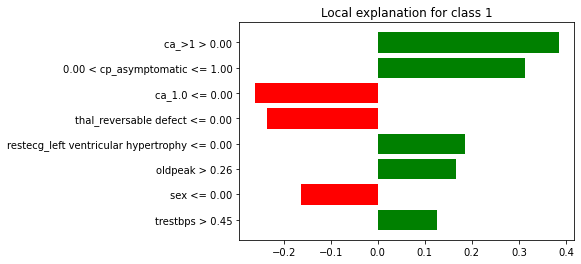

In [33]:
_=exp_mlp.as_pyplot_figure()
_.savefig('local_lime_hd_mlp.png',dpi = 300,bbox_inches='tight')

## 5. VIPOR

In [11]:
# define the POR function for skilearn models
def por (var, X_frame, model):
    X_frame = pd.DataFrame(X_frame)
    var_split = var.split('_')
    if len(var_split) == 1:
        var_sub = var_split[0]
    else:
        var_sub = var_split[0]+'_' 
    var_list = list(filter(lambda x: var_sub in x, X_frame.columns))
    if len(var_list)==0:
        return('Error: variale name is not in the data.')
    elif len(var_list)==1 and X_frame[var_list].nunique().values[0] ==2:
        # binary variables 
        input_temp_1 = X_frame.copy()
        input_temp_2 = X_frame.copy()
        input_temp_1[var] = 1  # condition on all xq = 1
        input_temp_2[var] = 0      
        prob_var1 = model.predict_proba(input_temp_1)[:,1]
        prob_var2 = model.predict_proba(input_temp_2)[:,1]
        log_or = np.log(prob_var1 + 0.00001) + np.log(1 - prob_var2 + 0.00001)-np.log(prob_var2 + 0.00001) - np.log(1 - prob_var1 + 0.00001)
        or_var = np.exp(log_or)
        #or_var = pd.Series(or_var)
        or_var = pd.Series(prob_var1/(1-prob_var1)*(1-prob_var2)/prob_var2)
    elif len(var_list)==1  and X_frame[var_list].nunique().values[0] >=2:
        #continuous variables
        input_temp_1 = X_frame.copy()
        input_temp_2 = X_frame.copy()
        input_temp_1[var] = 1
        input_temp_2[var] =  0
        prob_var1 = model.predict_proba(input_temp_1)[:,1]
        prob_var2 = model.predict_proba(input_temp_2)[:,1]
        log_or = np.log(prob_var1 + 0.00001) + np.log(1 - prob_var2 + 0.00001)-np.log(prob_var2 + 0.00001) - np.log(1 - prob_var1 + 0.00001)
        or_var = np.exp(log_or)
        #or_var = pd.Series(or_var)
        #or_var = pd.Series(prob_var1/(1-prob_var1)*(1-prob_var2)/prob_var2)
    else:
        # categorical variables
        input_temp_1 = X_frame.copy()
        input_temp_2 = X_frame.copy()
        input_temp_1[var] = 1
        input_temp_2[var] = 0
        input_temp_1[[x for x in var_list if x != var]] = 0
        input_temp_2[[x for x in var_list if x != var]] = 0
        prob_var1 = model.predict_proba(input_temp_1)[:,1]
        prob_var2 = model.predict_proba(input_temp_2)[:,1]
        log_or = np.log(prob_var1 + 0.00001) + np.log(1 - prob_var2 + 0.00001)-np.log(prob_var2 + 0.00001) - np.log(1 - prob_var1 + 0.00001)
        or_var = np.exp(log_or)
        #or_var = pd.Series(prob_var1/(1-prob_var1)*(1-prob_var2)/prob_var2)
        #or_var = pd.Series(prob_var1/prob_var2)
    return or_var

In [14]:
vipor_rf = pd.DataFrame(0,index=np.arange(X_train.shape[0]), columns=X_train.columns)
for var in X_train.columns:
    vipor_rf[var] = por(var,X_train,rf)

In [25]:
#vipor_rf.to_csv('vipor_heart_disease_train_rf.csv',index=False)

Text(0.5, 1.0, 'log (POR)')

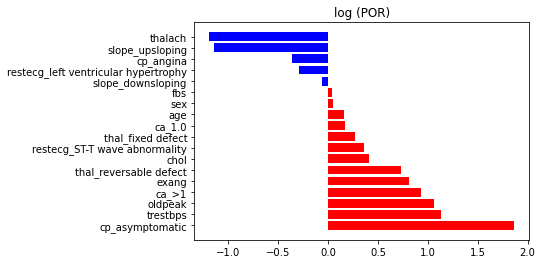

In [15]:
log_or_rf = np.log(vipor_rf.iloc[0])
log_or_rf1=log_or_rf.sort_values(ascending=False)
clrs = ['red' if ( x >0 ) else 'blue' for x in log_or_rf1.values ]
#log_or_rf1.plot(kind="barh",title='log(or)')
#.savefig('local_vipor_hd_rf.png',dpi = 300,bbox_inches='tight')
#fig = plt.figure(figsize = (10, 5))
plt.barh(log_or_rf1.index.to_list(), log_or_rf1.values.tolist(),color = clrs)
plt.title('log (POR)')
#plt.savefig('local_vipor_hd_rf.png',dpi = 300,bbox_inches='tight')

In [142]:
vipor_xgb = pd.DataFrame(0,index=np.arange(X_train.shape[0]), columns=X_train.columns)
for var in X_train.columns:
    vipor_xgb[var] = por(var,X_train,xgb)

In [71]:
#vipor_xgb.to_csv('vipor_heart_disease_train_xgb.csv',index=False)

In [16]:
#log_or_xgb = np.log(vipor_xgb.iloc[0])
#log_or_xgb.sort_values(ascending=False).plot(kind="barh",title='log(or)')

In [28]:
vipor_mlp = pd.DataFrame(0,index=np.arange(X_train.shape[0]), columns=X_train.columns)
for var in X_train.columns:
    vipor_mlp[var] = por(var,X_train,mlp)

In [29]:
#vipor_mlp.to_csv('vipor_heart_disease_train_mlp.csv',index=False)

In [17]:
#log_or_mlp = np.log(vipor_mlp.iloc[0])
#log_or_mlp1=log_or_mlp.sort_values(ascending=False)
#clrs = ['red' if ( x >0 ) else 'blue' for x in log_or_mlp1.values ]
#plt.barh(log_or_mlp1.index.to_list(), log_or_mlp1.values.tolist(),color = clrs)
#plt.title('log (POR)')
#plt.savefig('local_vipor_hd_mlp.png',dpi = 300,bbox_inches='tight')

## 7. Build-in variable importance at global level

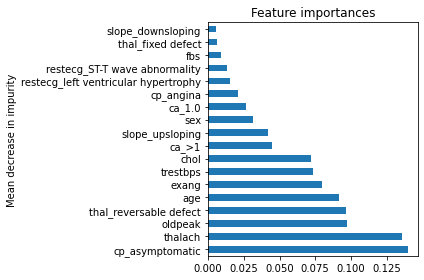

In [33]:
# rf: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import matplotlib.pyplot as plt
imp_rf = rf.feature_importances_
imp_rf = pd.Series(imp_rf, index=X_train.columns)


fig, ax = plt.subplots()
imp_rf.sort_values(ascending=False).plot(kind='barh')
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('scikit_learn_hd_rf.png',dpi = 300,bbox_inches='tight')

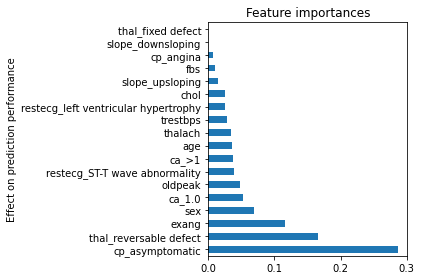

In [179]:
# xgb: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
imp_xgb = xgb.feature_importances_
imp_xgb = pd.Series(imp_xgb, index=X_train.columns)

fig, ax = plt.subplots()
imp_xgb.sort_values(ascending=False).plot(kind='barh')
ax.set_title("Feature importances")
ax.set_ylabel("Effect on prediction performance")
fig.tight_layout()

In [121]:
# mlp, no build-in variable importance method!!
#imp_mlp = mlp.feature_importances_
#imp_mlp = pd.Series(imp_mlp, index=X_train.columns)#

#fig, ax = plt.subplots()
#imp_mlp.plot(kind='barh')
#ax.set_title("Feature importances")
#ax.set_ylabel("Effect on prediction performance")
#fig.tight_layout()

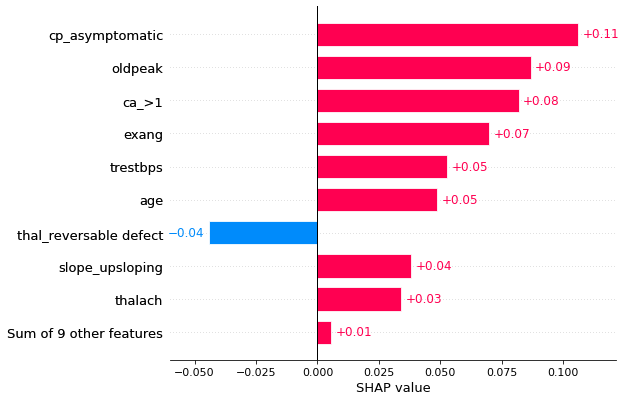

In [104]:
shap.plots.bar(Tree_shap_values_rf[0,:,1])